# Experimentation + Write and test .py files
Write simple AIScraper.py file for PoC frontend for simple webscraper RAG system (with OpenAI and LangChain)

**[Insert Architecture/Framework Diagram]**

---
## Inspiration source

https://www.youtube.com/watch?v=eLV1R6ORRyU&t=1s

---
## For README.md
**Create a Retrieval Augmented Generation (RAG) system that has the following characteristics:**
- Scrapes a relevant website to obtain Knowledge Documents
- Splits text into chunks and runs Ollama Embeddings Model to convert chunks into vector embeddings.
- Stores in "In-memory" vector store. 
- Returns relevant documents (context/knowledge) to combine with query vector -> to produce "information-rich" prompt
- Use OpenAI model (with OpenAI key) to generate contextualized output answer. 

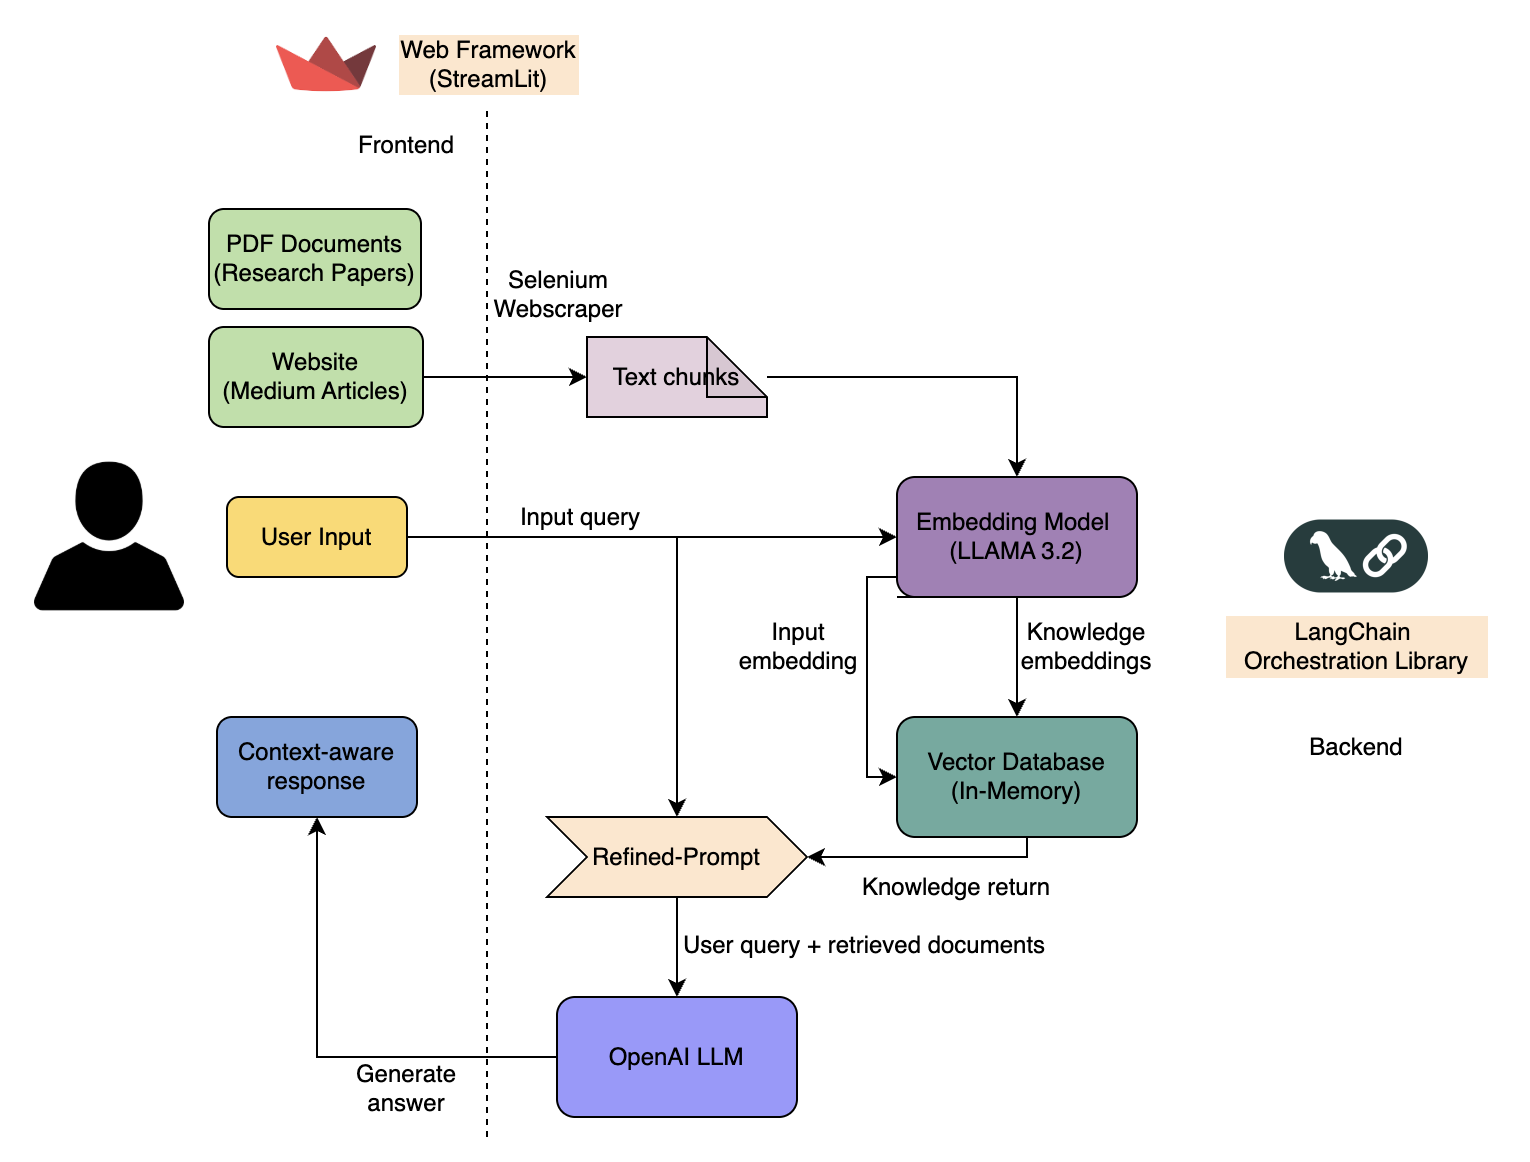

In [21]:
from IPython.display import Image, display
display(Image(filename='../images/rag_webscraper.png', width=900))

In [23]:
%%writefile research_assistantv1.py 
# import dependencies
import streamlit as st
from langchain_community.document_loaders import SeleniumURLLoader, PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_ollama import OllamaEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langchain_ollama.llms import OllamaLLM
import nltk

# download tools from NLTK library
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Prompt template for LLM
template = """
    You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. \
    If you don't know the answer, say that you don't know. Use three sentences maximum and keep the answer concise.
    Question: {question}
    Context: {context}
    Answer: 
"""

embeddings = OllamaEmbeddings(model="llama3.2")
vector_store = InMemoryVectorStore(embeddings)

# Instantiate LLM
model = OllamaLLM(model="llama3.2")

# load webpage contents
def load_page(url): 
    loader = SeleniumURLLoader(
        urls=[url],
        headless=False #run in non-headless mode for Cloudflare to see a real browser
    )
    documents = loader.load()
    return documents

# load pdf contents
def load_pdf(uploaded_file): 
    with open("temp.pdf", "wb") as f:
        f.write(uploaded_file.read())
    return PyPDFLoader("temp.pdf").load()

# Split text into smaller documents - that can fit better to LLM context window, for loading into vector database/in-memory vector store. 
def split_text(documents):
    if not documents: 
        return []
    text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
        chunk_overlap=200, 
        add_start_index=True
    )
    data = text_splitter.split_documents(documents)
    return data

# Index documents with embeddings model and vector store - Split docs would be converted to embeddings (emb model) and stored in vector store.
def index_docs(documents): 
    vector_store.add_documents(documents)

# Retrieve docs - Based on user query.
def retrieve_docs(query):
    return vector_store.similarity_search(query)

# pass context-rich combined prompt to LLM to generate fontext-aware response.
def answer_question(question, context): 
    prompt = ChatPromptTemplate.from_template(template)
    chain = prompt | model
    return chain.invoke({"question": question, "context": context})

# Streamlit config? 
st.title("Research Assistant")
url = st.text_input("Enter URL:")
upload = st.file_uploader("Upload a PDF file", type=["pdf"])
documents = []

# load content type - select one.
if url: 
    documents = load_page(url)
elif upload: 
    documents = load_pdf(upload)

# perform pipeline steps
chunked_docs = split_text(documents)
index_docs(chunked_docs)

# use query question to retrieve docs
question = st.chat_input()
if question: 
    st.chat_message("user").write(question) #display user's question.
    retrieve_documents = retrieve_docs(question)
    context = "\n\n".join(doc.page_content for doc in retrieve_documents)
    answer = answer_question(question, context)
    st.chat_message("assistant").write(answer) #display answer.

Overwriting ai_scraper.py


In [4]:
%%writefile research_assistantv2.py 
# import dependencies
import streamlit as st
from langchain_community.document_loaders import SeleniumURLLoader, PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langchain_ollama.llms import OllamaLLM
import nltk

# download tools from NLTK library
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Prompt template for LLM
template = """
    You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. \
    If you don't know the answer, say that you don't know. Use three sentences maximum and keep the answer concise.
    Question: {question}
    Context: {context}
    Answer: 
"""

# define embeddings model for vector store
model_name = "hkunlp/instructor-large"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': True}
hf = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

# Instantiate LLM
model = OllamaLLM(model="llama3.2")

# load webpage contents
def load_page(url): 
    loader = SeleniumURLLoader(
        urls=[url],
        headless=False #run in non-headless mode for Cloudflare to see a real browser
    )
    documents = loader.load()
    return documents

# load pdf contents
def load_pdf(uploaded_file): 
    with open("docs/temp.pdf", "wb") as f:
        f.write(uploaded_file.read())
    return PyPDFLoader("docs/temp.pdf").load()

# Split text into smaller documents - that can fit better to LLM context window, for loading into vector database/in-memory vector store. 
def split_text(documents):
    if not documents: 
        return []
    text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
        chunk_overlap=200, 
        add_start_index=True
    )
    data = text_splitter.split_documents(documents)
    return data

# Retrieve docs - Based on user query.
def retrieve_docs(query, vector_store):
    retriever = vector_store.as_retriever(search_type="similarity", search_kwargs={"k": 12})
    retrieved_docs = retriever.invoke(query)
    return retrieved_docs

# pass context-rich combined prompt to LLM to generate fontext-aware response.
def answer_question(question, context): 
    prompt = ChatPromptTemplate.from_template(template)
    chain = prompt | model
    return chain.invoke({"question": question, "context": context})

# Streamlit config? 
st.title("Research Assistant")
url = st.text_input("Enter URL:")
upload = st.file_uploader("Upload a PDF file", type=["pdf"])
documents = []

# load content type - select one.
if url: 
    documents = load_page(url)
elif upload: 
    documents = load_pdf(upload)

# perform pipeline steps
if documents: 
    chunked_docs = split_text(documents)
    vector_store = Chroma.from_documents(documents=chunked_docs, embedding=hf, persist_directory="chroma_db")

# use query question to retrieve docs
question = st.chat_input()
if question: 
    st.chat_message("user").write(question) #display user's question.
    retrieve_documents = retrieve_docs(question, vector_store)
    context = "\n\n".join(doc.page_content for doc in retrieve_documents)
    answer = answer_question(question, context)
    st.chat_message("assistant").write(answer) #display answer.

Overwriting research_assistantv2.py


In [5]:
# Test functions
from langchain_community.document_loaders import SeleniumURLLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_ollama import OllamaEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langchain_ollama.llms import OllamaLLM

In [6]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jinkettyee/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jinkettyee/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Modifications to "load_page" function: 
- Current function too basic, does not load webpages with "Cloudflare's bot protection page" like Medium articles.
- "Cloudflare's bot protection page" blocks or delays automated access by tools like Selenium.
- **Solution:** Run in non-headless mode for Cloudflare to see a real browser

In [15]:
# load webpage contents
def load_page(url): 
    loader = SeleniumURLLoader(
        urls=[url],
        headless=False #run in non-headless mode for Cloudflare to see a real browser
    )
    documents = loader.load()
    return documents

In [16]:
docs = load_page("https://medium.com/mitb-for-all/talking-data-using-automatic-speech-recognition-to-power-language-models-9725f0c0b2da")

In [17]:
first_doc = docs[0]
print(first_doc.page_content)

Open in app

Sign in

Write

Sign in

MITB For All

Follow publication

MITB For All

Tech contents related to AI, Analytics, Fintech, and Digital Transformation. Written by MITB Alumni; open-access for everyone.

Follow publication

Talking Data — Using Automatic Speech Recognition to Power Language Models

Jinkett A. Yee

Jinkett A. Yee

10 min read

Apr 18, 2025

--

In today’s digital age, audio content is rapidly gaining popularity across platforms such as Instagram Reels, TikTok, YouTube, and podcasts (Guttmann, 2024). This global trend has resulted in a massive volume of spoken language data — representing a rich and largely untapped source of high-quality textual information. When transcribed accurately, this audio data can serve as valuable input for downstream tasks that require contextually nuanced language understanding.

Unlike conventional web-scraped text, which often suffers from inconsistencies, noise, and lack of structure — as discussed in our earlier study on featur

## Test LangChain PDF Loader Function

In [7]:
from langchain_community.document_loaders import PyPDFLoader

file_path = "docs/eyecatcher-project-report.pdf"
loader = PyPDFLoader(file_path)

docs = loader.load()
print(docs[5].page_content)

5 
3.1.3. Model Training 
ResNet50 
ResNet 50 is a deep convolutional neural network that employs residual networks. It introduced skip connections 
to address the vanishing gradient problems, enabling the training of deeper networks. (Kaiming He, et.al, 2015) 
While at its inception it achieved the state-of-the-art results, other model architectures have since surpassed it. 
However, it remains as one of the more popular models due to the simplicity of understanding the model.  
Vision Transformer (ViT-16)  
Vision Transformer is an image clas sification architecture that employs transformer architecture to process 
images. It divides the input images into patches and process them through a series of self -attention layers, 
enabling long-range interaction between image elements. The model also eliminates the need for convolutional 
layers, allowing us to capture global dependencies in the image.  
In the training step, the team has frozen all the feature extraction layers, finetuned 

### Use Langchain ChromaDB vector store for better parameter control and explainability

In [8]:
# import additional dependencies
from langchain_huggingface import HuggingFaceEmbeddings

In [9]:
# define embeddings model for vector store
model_name = "hkunlp/instructor-large"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': True}
hf = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

In [10]:
# Split text into smaller documents - that can fit better to LLM context window, for loading into vector database/in-memory vector store. 
def split_text(documents):
    if not documents: 
        return []
    text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
        chunk_overlap=200, 
        add_start_index=True
    )
    data = text_splitter.split_documents(documents)
    return data

In [11]:
# Split and index (with embeddings model and in-memory vector store)
chunks = split_text(docs)

# Index documents with embeddings model and vector store - Split docs would be converted to embeddings (emb model) and stored + indexe in vector store.
vector_store = Chroma.from_documents(documents=chunks, embedding=hf)

In [12]:
# check length of documents in vector store vs expected count
print(f"Expected docs: {len(chunks)}")

# check no. of docs in ChromaDB vectorstore
num_docs = len(vector_store.get()['documents'])
print(f"Vector store holds {num_docs} documents.")

Expected docs: 58
Vector store holds 58 documents.


### Test query retrieval and answer generation pipelines (with ChromaDB as vector store and NEW embedding model - "hkunlp/instructor-large"

In [13]:
# Retrieve docs - Based on user query.
def retrieve_docs(query, vector_store):
    retriever = vector_store.as_retriever(search_type="similarity", search_kwargs={"k": 12})
    retrieved_docs = retriever.invoke(query)
    return retrieved_docs

# pass context-rich combined prompt to LLM to generate fontext-aware response.
def answer_question(question, context): 
    prompt = ChatPromptTemplate.from_template(template)
    chain = prompt | model
    return chain.invoke({"question": question, "context": context})

In [14]:
# Instantiate LLM
model = OllamaLLM(model="llama3.2")

# Prompt template for LLM
template = """
    You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. \
    If you don't know the answer, say that you don't know. Use three sentences maximum and keep the answer concise.
    Question: {question}
    Context: {context}
    Answer: 
"""

question = "Explain the model building workflow."
retrieve_documents = retrieve_docs(question, vector_store)
context = "\n\n".join(doc.page_content for doc in retrieve_documents)
answer = answer_question(question, context)

ConnectError: [Errno 61] Connection refused

In [24]:
print(answer)

The model building workflow involves a sequence of steps: preprocessing, training, evaluation, and registration. The team uses AWS CodePipeline to automate this process, which includes using SageMaker Pipeline for various stages of training, such as data preprocessing and model training. This workflow is designed to ensure both model accuracy and system reliability.


In [25]:
# print each document's content
for i, doc in enumerate(retrieve_documents):
    print(f"--- Document {i+1} ---")
    print(doc.page_content)

--- Document 1 ---
13 
Figure F: Detailed Architecture for Model Building
 
 
Figure G: CodePipeline Stages for Model Building
--- Document 2 ---
14 
Figure H: Detailed Architecture for Model Deployment
--- Document 3 ---
deployment workflow that maximizes both model accuracy and system  reliability. 
Our workflow is designed as a sequence of steps: Build, Deploy to Staging, Approve Production Deployment, and 
Deploy to Production. The workflow init iated either when modifications a re made to the model deployment 
source code or when a new model gets approved in the model registry . The workflow then builds a package 
from the repository, which encompasses both our staging and production deployment CloudFormation 
template. 
Utilizing the template, the workflow updates the stacks in CloudFormation. This either results in the creation or 
the update of the SageMaker endpoint in the staging environment. Following these updates, we execute an 
inference test on the staging endpoint. 
The